## [Question 1] Write code to estimate the treatment effects if a ‘different room is assigned’ as the treatment indicator and interpret its effect on the room being ‘canceled’. Use all the other columns as the covariates. Write your observations for the results.

In [1]:
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data1 = pd.read_csv('/Users/zhongjinying/Downloads/hotel_cancellation.csv')
data1

,Unnamed: 0,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,days_in_waiting_list,different_room_assigned,is_canceled
0,3,13,2015,27,1,0,False,False
1,4,14,2015,27,1,0,False,False
2,5,14,2015,27,1,0,False,False
3,7,9,2015,27,1,0,False,False
4,8,85,2015,27,1,0,False,True
...,...,...,...,...,...,...,...,...
102889,119385,23,2017,35,30,0,False,False
102890,119386,102,2017,35,31,0,False,False
102891,119387,34,2017,35,31,0,False,False
102892,119388,109,2017,35,31,0,False,False


In [3]:
# y: being canceled; x: different room is assigned => change these two as binary values 0/1
data1['is_canceled'] = data1['is_canceled'].astype(int)
data1['different_room_assigned'] = data1['different_room_assigned'].astype(int)

In [4]:
X = data1.drop(['Unnamed: 0'], axis=1)
X = X.drop(['is_canceled'], axis=1)
y = data1['is_canceled']
# standardization to reduce scaling effects
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

In [5]:
model = sm.Logit(y, X).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            is_canceled   No. Observations:               102894
Model:                          Logit   Df Residuals:                   102888
Method:                           MLE   Df Model:                            5
Date:                Tue, 14 Feb 2023   Pseudo R-squ.:                  0.1053
Time:                        22:16:25   Log-Likelihood:                -61576.
converged:                       True   LL-Null:                       -68825.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
lead_time                     0.0052   6.83e-05     76.109      0.000       0.

In [6]:
coef = model.params['different_room_assigned']
print("The treatment effects of different room assigned is", round(coef,2))
print("Exponential Value is: ", round(math.exp(coef),2))

The treatment effects of different room assigned is -2.52
Exponential Value is:  0.08


The coefficient of different_room_assigned variable is -2.52, which means the odds of cancellation will be multiplied by 0.08 when different room is assigned. The logit coefficients of lead_time and days_in_waiting_list are positive and others are negative. Besides, if we set the significant level at 0.05, arrival_date_day_of_month is not statistically significant. Lastly, in the output, we could see that the in-sample R^2 only reach 10%, which means this model only (poorly) explained around 10% variability in the dependent variable with this dataset. 

## [Question 2] Use double logit regression to measure the effect of ‘different room is assigned’ on the room being ‘canceled’..

In [149]:
model_1 = sm.Logit(y,X).fit()
y_hat = np.array(model_1.predict(X).values.reshape(len(X),1))

X_new = np.hstack((X,y_hat))
model_2 = sm.Logit(y, X).fit()
print(model_2.params)

Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598443
         Iterations 7
lead_time                    0.005202
arrival_date_year           -0.000375
arrival_date_week_number    -0.004168
arrival_date_day_of_month   -0.001143
days_in_waiting_list         0.001325
different_room_assigned     -2.518556
dtype: float64


We still get similar treatment effects using double logit regression. The coefficients of different_room_assigned is around -2.52, which means the odds of cancellation will be multiplied by 0.08 when different room is assigned.

## [Question 3] Use bootstrap to estimate the standard error of the treatment effects measured in (2).

In [167]:
n_resamples = 1000
treat_effects = np.zeros((n_resamples, model_2.params.shape[0]-1))

i = 0
while i < n_resamples:
    resample_index = np.random.choice(data1.index, size = data1.index.size, replace = True)
    resample = data1.iloc[resample_index]
    x_resample = X.iloc[resample_index]
    y_resample = y.iloc[resample_index]
    
    model1 = sm.Logit(y_resample, x_resample).fit()
    y_hat = np.array(model1.predict(x_resample).values.reshape(len(y_hat),1))
    x_new = np.hstack((x_resample, y_hat))
    model2 = sm.Logit(y_resample, x_new).fit()
    
    treat_effects[i, :] = model_2.params[:-1]
    i += 1
    
treat_effects_se = treat_effects.std(axis=0)

print("Standard errors of the treatment effects:")
print(treat_effects_se)

Optimization terminated successfully.
         Current function value: 0.598509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598417
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596747
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596695
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597645
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597560
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598802
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598773
  

Optimization terminated successfully.
         Current function value: 0.598261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599144
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599057
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598363
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599168
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597140
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597093
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599857
  

Optimization terminated successfully.
         Current function value: 0.597185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597169
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596423
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596351
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598619
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598545
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598552
  

Optimization terminated successfully.
         Current function value: 0.598593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598509
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599684
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598453
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598466
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597108
  

Optimization terminated successfully.
         Current function value: 0.597646
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600421
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600316
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599725
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599591
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599464
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599407
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600864
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600812
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600996
  

Optimization terminated successfully.
         Current function value: 0.599255
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598229
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598178
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597309
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596875
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600019
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598745
  

Optimization terminated successfully.
         Current function value: 0.599067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599036
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598361
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596742
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596720
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600307
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600180
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596114
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596046
  

Optimization terminated successfully.
         Current function value: 0.599584
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597836
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597763
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598716
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597719
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599118
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600014
  

Optimization terminated successfully.
         Current function value: 0.599498
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599994
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599890
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598552
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598500
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598993
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598897
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597822
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597816
  

Optimization terminated successfully.
         Current function value: 0.596147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597566
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597561
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598945
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598892
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597566
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597440
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597600
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597526
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600372
  

Optimization terminated successfully.
         Current function value: 0.600708
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598499
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598444
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598254
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598214
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597577
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598312
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598220
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598361
  

Optimization terminated successfully.
         Current function value: 0.598029
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597984
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597007
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596985
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597432
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597411
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598147
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599752
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599718
  

Optimization terminated successfully.
         Current function value: 0.596641
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596610
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598070
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597931
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598043
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597971
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597883
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598478
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598302
  

Optimization terminated successfully.
         Current function value: 0.600171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595997
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.595979
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597643
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596420
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596386
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599007
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598920
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598654
  

Optimization terminated successfully.
         Current function value: 0.600101
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600014
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598556
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598471
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599318
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597866
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597822
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596799
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596691
  

Optimization terminated successfully.
         Current function value: 0.597218
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597185
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598532
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597908
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597865
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598301
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598248
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598009
  

Optimization terminated successfully.
         Current function value: 0.598531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597276
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598282
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598049
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598231
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598136
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597719
  

Optimization terminated successfully.
         Current function value: 0.599230
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599847
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599804
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596967
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597511
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598857
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598834
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598150
  

Optimization terminated successfully.
         Current function value: 0.600555
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600530
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600148
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596690
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598020
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597957
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597353
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597275
  

Optimization terminated successfully.
         Current function value: 0.596452
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596388
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600161
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.600102
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597755
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597711
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598891
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599502
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599421
  

Optimization terminated successfully.
         Current function value: 0.599545
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597381
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597783
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597764
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597932
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597830
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597946
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597895
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599266
  

Optimization terminated successfully.
         Current function value: 0.597823
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597750
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599901
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599862
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596566
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596446
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598463
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598408
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599672
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599583
  

Optimization terminated successfully.
         Current function value: 0.598310
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599011
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598973
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597184
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597084
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597067
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598197
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598171
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598109
  

Optimization terminated successfully.
         Current function value: 0.598482
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599515
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599490
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598702
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598663
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597438
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597403
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599426
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599392
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596345
  

Optimization terminated successfully.
         Current function value: 0.596505
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.596484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597122
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597027
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599299
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599249
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.599068
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598906
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598168
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598131
  

## [Question 4] drinking RDD

In [ ]:
# Keeping 21 as the threshold for age, explore the data with an RDDlen(data3)
# determine if alcohol increases the chances of death by accident, suicide and/or otherslen(data3)

In [ ]:
data3 = pd.read_csv('/Users/zhongjinying/Downloads/drinking.csv')
data3 = data3.dropna()
data3.head(5)

In [94]:
## choose the bandwidth to be 1 year (i.e., 21 +- 1)
bandwidth = 1
threshold = 21

In [102]:
## calculate the changes
def drinking(bandwidth, threshold):
    upper = threshold + bandwidth
    lower = threshold - bandwidth
    data3['tag'] = np.where((data3['age'] > threshold) & (data3['age'] <= upper), 'above', 
                            np.where((data3['age'] >= lower) & (data3['age'] < threshold), 'below', 'out of range'))
    
    ## if alcohol increases the chances of death by accident, suicide and/or others (the three given columns) 
    # average to one side of the threshold minus average to the other side

    # accident
    average_accident_below = data3[data3['tag'] == 'below']['accident'].mean()
    average_accident_above = data3[data3['tag'] == 'above']['accident'].mean()
    effect_accident = average_accident_above - average_accident_below

    # suicide
    average_suicide_below = data3[data3['tag'] == 'below']['suicide'].mean()
    average_suicide_above = data3[data3['tag'] == 'above']['suicide'].mean()
    effect_suicide = average_suicide_above - average_suicide_below

    # others
    average_others_below = data3[data3['tag'] == 'below']['others'].mean()
    average_others_above = data3[data3['tag'] == 'above']['others'].mean()
    effect_others = average_others_above - average_others_below

    print("change in accident:", round(effect_accident,2), "\n", "change in suicide:", round(effect_suicide,2), "\n", "change in others:", round(effect_others,2))

In [103]:
drinking(bandwidth, threshold)

change in accident: 1.34 
 change in suicide: 1.72 
 change in others: 6.54


### “Should the legal age for drinking be reduced from 21?”
No. All the results are positive, which means that alcohol does increase the chances of death by accident, suicide and/or others based on RDD method. Thus, the legal age for drinking should not be reduced from 21, as the drinking will incresase the happens of accident/suicide/others. To be more specific, if the sample data is representative, drinking improves the chances in others for about 7, suicide for around 2, and accident for around 1.3. We need to avoid any death or risks after drinking as much as possible, we should reduce the age from 21.

In [97]:
# Plot graphs to show the discontinuity
# show results for the change in chances of death with all the three features

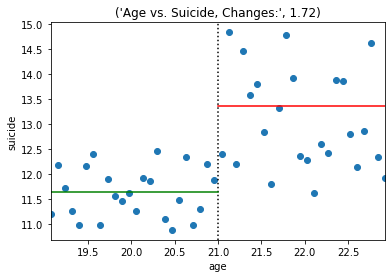

In [101]:
plt.scatter(data3['age'], data3['suicide'])
plt.xlabel('age')
plt.ylabel('suicide')
title = 'Age vs. Suicide, Changes:' , round(effect_suicide,2)
plt.title(title)
plt.axvline(x=threshold, color='black', linestyle=':')
#plt.axhline(y=average_suicide_above, color='red', linestyle='-')
#plt.axhline(y=average_suicide_below, color='green', linestyle='-')

# avg line for below group
x1 = min(data3[data3['age'] < threshold]['age'])
y1 = average_suicide_below
x11 = threshold
x_below = [x1,x11]
y_below = [y1,y1]
plt.plot(x_below, y_below, color='green')

# avg line for above group
x2 = max(data3[data3['age'] > threshold]['age'])
y2 = average_suicide_above
x22 = threshold
x_above = [x2,x22]
y_above = [y2,y2]
plt.plot(x_above, y_above, color='red')

plt.xlim(x1, x2)
plt.show()

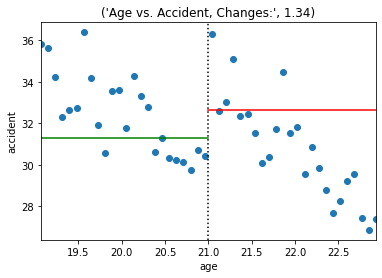

In [99]:
plt.scatter(data3['age'], data3['accident'])
plt.xlabel('age')
plt.ylabel('accident')
title = 'Age vs. Accident, Changes:' , round(effect_accident,2)
plt.title(title)
plt.axvline(x=threshold, color='black', linestyle=':')

# avg line for below group
# x1 = min(data3[data3['age'] < threshold]['age'])
# x11 = threshold
y1 = average_accident_below
x_below = [x1,x11]
y_below = [y1,y1]
plt.plot(x_below, y_below, color='green')

# avg line for above group
# x2 = max(data3[data3['age'] > threshold]['age'])
# x22 = threshold
y2 = average_accident_above
x_above = [x2,x22]
y_above = [y2,y2]
plt.plot(x_above, y_above, color='red')

plt.xlim(x1, x2)
plt.show()

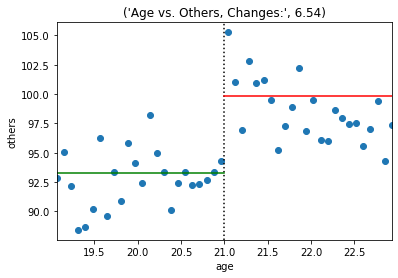

In [118]:
plt.scatter(data3['age'], data3['others'])
plt.xlabel('age')
plt.ylabel('others')
title = 'Age vs. Others, Changes:' , round(effect_others,2)
plt.title(title)
plt.axvline(x=threshold, color='black', linestyle=':')

# avg line for below group
# x1 = min(data3[data3['age'] < threshold]['age'])
# x11 = threshold
y1 = average_others_below
x_below = [x1,x11]
y_below = [y1,y1]
plt.plot(x_below, y_below, color='green')

# avg line for above group
# x2 = max(data3[data3['age'] > threshold]['age'])
# x22 = threshold
y2 = average_others_above
x_above = [x2,x22]
y_above = [y2,y2]
plt.plot(x_above, y_above, color='red')

plt.xlim(x1, x2)
plt.show()

### What might be the effect of choosing a smaller bandwidth?  

In [104]:
drinking(0.5, 21)

change in accident: 3.38 
 change in suicide: 1.85 
 change in others: 8.35


In [105]:
drinking(0.3, 21)

change in accident: 4.0 
 change in suicide: 1.88 
 change in others: 8.37


In [106]:
drinking(0.1, 21)

change in accident: 5.9 
 change in suicide: 0.52 
 change in others: 11.0


As we can see, the effects of drinking become even more obvious. The chances of these three features are increasing when we choose smaller bandwidth. More specifically, the chances of death with others increased from 6.54 (bandwidth = 1) to 11 (bandwidth = 0.1), chances of accidents increased from 1.34 (bw = 1) to 5.9 (bw = 0.1).

### What if we chose the maximum bandwidth?

In [119]:
(threshold - x1)==(x2 - threshold) #TRUE
maximum_bandwidth = threshold - x1

In [120]:
drinking(maximum_bandwidth, 21)

change in accident: -1.68 
 change in suicide: 1.44 
 change in others: 5.74


When we chose the maximum bandwidth, the findings of the effects towards death with accidents chnaged significantly. Previously, for all the bandwidths we tries (i.e., bandwidth <= 1), drinking will leads to higher chances in accidents, however, in this case, the result shows that it decreased the chances in accident. This might caused by the confounding variables as we incude not only the data close to the threshold but also the data far from it. 

## [Question 5] iris KNN

In [191]:
data5 = pd.read_csv('/Users/zhongjinying/Downloads/iris.csv')
data5 = data5.dropna()
data5.head(5)

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [202]:
#  How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7?
x = data5.drop("variety", axis=1).values
y = data5["variety"].values
k = [1, 3, 5, 7]
score_list = []
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

### How does the performance of k-nearest neighbors change as k takes on the following values: 1, 3, 5, 7? 

In [206]:
for n in k:
    knn = KNeighborsClassifier(n_neighbors = n, metric = 'euclidean')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy score when k = {n}: {accuracy}\n")

Accuracy score when k = 1: 0.9

Accuracy score when k = 3: 0.9333333333333333

Accuracy score when k = 5: 0.9666666666666667

Accuracy score when k = 7: 0.9333333333333333



The optimal value of k is 5, as it achieves the highest accuracy score. 

### Which distance/similarity metric did you choose to use and why?

In [208]:
# manhattan
for n in k:
    knn = KNeighborsClassifier(n_neighbors = n, metric = 'manhattan')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for k = {n}: {accuracy}")

Accuracy for k = 1: 0.9
Accuracy for k = 3: 0.9333333333333333
Accuracy for k = 5: 0.9333333333333333
Accuracy for k = 7: 0.9333333333333333


In [210]:
# minkowski
for n in k:
    knn = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski')
    knn.fit(x_train, y_train)
    y_pred = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for k = {n}: {accuracy}")

Accuracy for k = 1: 0.9
Accuracy for k = 3: 0.9333333333333333
Accuracy for k = 5: 0.9666666666666667
Accuracy for k = 7: 0.9333333333333333


I choose to use Euclidean distance as: (1) Based on the results, Euclidean achieved relative better results compared to Manhattan distance; (2) It is easy-to-compute, and it's also the simplest and most straight-forward distance metric.